Ziff-Gulari-Barshad model: Steady State Conditions.
---------------------------------------------------
The mechanism being studied frequently involves several intermediary species, which
concentrations (partial pressure for species in the gas phase and coverage fraction for
species that are adsorbed) change in a particular manner as the simulation progresses.
However, after a particular simulation time, the concentration of all intermediate
species remains constant. At that point, we say the system has reached a steady state
configuration. Sadly, we are unable to anticipate the simulation time at which that
stage will be reached. Therefore, the more logical approach to take is to: 1) run the
simulation for a set period of time (initial guess), 2) determine if the system has
reached a steady state, and 3) if so, consider the calculation to have converged and
stop; otherwise, increase the simulation time and resume repeating all steps until
convergence. With **pyZacros**, and much more directly with **Zacros**, this is laborious to
complete manually. Thus, this tutorial aims to demonstrate how to accomplish this goal
using the class ``ZacrosSteadyStateJob`` from the **pyZacros** extended components.

The first step is to import all packages we need:

In [1]:
import numpy
import scm.pyzacros as pz
import scm.pyzacros.models

Then, we initialize the **pyZacros** environment. 

In [2]:
scm.pyzacros.init()

PLAMS working folder: /home/aguirre/Develop/pyzacros/examples/ZiffGulariBarshad/plams_workdir.010


Notice this command created the directory where all **Zacros** input and output files
will be stored if they are needed for future reference (``plams_workdir`` by default).
Typically, the user doesn't need to use these files.

First, we define the physical system to study. Here we used the Ziff-Gulari-Bashard model.
This simple model describes the catalytic processes of carbon monoxide oxidation to carbon
dioxide ($\text{CO}+\frac{1}{2}\text{O}_2\longrightarrow \text{CO}_2$) and accurately
captures the interesting property of the phase transition between two surface poisoned
states (either CO- or O-poisoned) and a steady state in between. It is named after Robert
M. Ziff, Erdogan Gulari, and Yoav Barshad's pioneering work in 1986.

In [3]:
zgb = pz.models.ZiffGulariBarshad()

Now set up the Zacros calculation. All parameters are set using a ``Setting`` object.
To begin, we define the physical parameters: the molar fractions of the gas species
(``CO`` and ``O2``), the temperature (in K), and the pressure (in bar). The calculation
parameters are then set: ``species numbers`` (in s) determines how frequently information
about the number of gas and surface species will be stored, ``max time`` (in s) specifies
the maximum allowed simulated time, and "random seed" specifies the random seed to make
the calculation precisely reproducible. Keep in mind that ``max time`` defines the
calculation's stopping criterion, and it is the parameter we will control below to
achieve the steady-state configuration. Finally, we create the ``ZacrosJob``, which
uses the parameters we just defined as well as the Ziff-Gulari-Bashard model's lattice,
mechanism, and cluster expansion. Notice we do not run this job, we use it as a reference
for the steady-state calculation described below.

In [4]:
z_sett = pz.Settings()
z_sett.molar_fraction.CO = 0.42
z_sett.molar_fraction.O2 = 1.0 - z_sett.molar_fraction.CO
z_sett.temperature = 500.0
z_sett.pressure = 1.0
z_sett.species_numbers = ('time', 0.1)
z_sett.max_time = 10.0
z_sett.random_seed = 953129

job = pz.ZacrosJob( settings=z_sett,
                    lattice=zgb.lattice,
                    mechanism=zgb.mechanism,
                    cluster_expansion=zgb.cluster_expansion )

It is now time to set up the steady state calculation. It also needs a ``Settings`` object to set its parameters, as shown in the first block of code below. To begin, we define the parameters for calculating the turn-over frequency (TOF), which is the property that will be monitored to determine convergence as the steady state is reached. More information can be found in TOF. In a nutshell, for a given simulation time (that will be increased systematically), the simulation is divided into an ``turnover_frequency.nbatch`` ensemble of contiguous batches (20 for this case) where the TOFs are calculated for each one. If the estimated confidence level for these TOFs is higher than the confidence level specified by the ``turnover frequency.confidence`` parameter (96% for this case), convergence is then considered to have been achieved. The ``nreplicas`` parameter allows several simulations to run in parallel to speed up the calculation at the expense of more computational power. For the time being, we will leave it at 1, but we will return to it later.

In the second block of code, the ``ZacrosSteadyStateJob.Parameters()`` class allows us to specify the grid in ``max time``, which in this case ranges from 20 to 1000 every 100 seconds. Take note that the convergence is verified for each point on this grid, and if it has not converged, the calculation is resumed up to the next point in ``max time``.

Finally, we create ``ZacrosSteadyStateJob``, which references the "ZacrosJob" defined above as well as the ``Settings`` object and parameters we just defined:

In [5]:
ss_sett = pz.Settings()
ss_sett.turnover_frequency.nbatch = 20
ss_sett.turnover_frequency.confidence = 0.96
ss_sett.nreplicas = 1

parameters = pz.ZacrosSteadyStateJob.Parameters()
parameters.add( 'max_time', 'restart.max_time', numpy.arange(20.0, 1000.0, 100) )

ss_job = pz.ZacrosSteadyStateJob( settings=ss_sett, reference=job, parameters=parameters )

[17.01|16:58:42] JOB plamsjob Steady State Convergence: Using nbatch=20,confidence=0.96,ignore_nbatch=1,nreplicas=1


The steady-state setup calculation is ready. Therefore, we can start the calculation by invoking the function ``run()``, which will provide access to the results via the ``results`` variable after it has been completed. The sentence involving the method ``ss_job.ok()``, verifies that the calculation was successfully executed, and waits for the completion of every executed thread in case of parallel execution.

In [6]:
results = ss_job.run()

if not ss_job.ok():
    print('Something went wrong!')

[17.01|16:58:42] JOB plamsjob STARTED
[17.01|16:58:42] JOB plamsjob RUNNING
[17.01|16:58:42] JOB plamsjob/plamsjob_ss_iter000 STARTED
[17.01|16:58:42] JOB plamsjob/plamsjob_ss_iter000 RUNNING
[17.01|16:58:43] JOB plamsjob/plamsjob_ss_iter000 FINISHED
[17.01|16:58:43] JOB plamsjob/plamsjob_ss_iter000 SUCCESSFUL
[17.01|16:58:43]       species            TOF          error          ratio     conv?
[17.01|16:58:43]            CO       -0.75520        0.12483        0.16529     False
[17.01|16:58:43]            O2       -0.39453        0.07267        0.18419     False
[17.01|16:58:43]           CO2        0.75640        0.12615        0.16678     False
[17.01|16:58:43] JOB plamsjob Steady State Convergence: NO CONVERGENCE REACHED YET
[17.01|16:58:43] JOB plamsjob/plamsjob_ss_iter001 STARTED
[17.01|16:58:43] JOB plamsjob/plamsjob_ss_iter001 RUNNING
[17.01|16:58:46] JOB plamsjob/plamsjob_ss_iter001 FINISHED
[17.01|16:58:46] JOB plamsjob/plamsjob_ss_iter001 SUCCESSFUL
[17.01|16:58:46]       sp

If the execution got up to this point, everything worked as expected. Hooray!
Now, in the following lines, we just nicely print the results in a table. See
the API documentation to learn more about the ``results`` object is structured.
Here we show the history of the simulation and see how it progresses as the
``max_time`` is increased. We print the TOF for CO2, its error, and whether
the calculation converged. Notice that the calculation should have been
converged at 720 s of ``max_time``.

In [14]:
print(60*'-')
fline = "{0:>8s}{1:>10s}{2:>15s}{3:>12s}{4:>10s}"
print( fline.format('iter', 'max_time', 'TOF_CO2', 'error', 'conv?') )
print( fline.format('', 's', 'mol/s/site', 'mol/s/site', '') )
print(60*'-')

for i,step in enumerate(results.history()):
    fline = "{0:8d}{1:>10.2f}{2:15.5f}{3:>12.5f}{4:>10s}"
    print( fline.format(i,
                        step['max_time'],
                        step['turnover_frequency']['CO2'],
                        step['turnover_frequency_error']['CO2'],
                        str(all(step['converged'].values()))) )

------------------------------------------------------------
    iter  max_time        TOF_CO2       error     conv?
                 s     mol/s/site  mol/s/site          
------------------------------------------------------------
       0     20.00        0.75640     0.12615     False
       1    120.00        0.59301     0.03157     False
       2    220.00        0.59360     0.03311     False
       3    320.00        0.59293     0.03062     False
       4    420.00        0.59345     0.02729     False
       5    520.00        0.61241     0.02564     False
       6    620.00        0.60345     0.02697     False
       7    720.00        0.60170     0.02183      True


Now that all calculations are done, we can close the pyZacros environment:

In [8]:
scm.pyzacros.finish()

[17.01|16:59:08] PLAMS run finished. Goodbye


Additionally, you can see the aforementioned results visually if you have
installed the package [matplotlib](https://matplotlib.org/). Please review
the code in the section below. In particular, pay close attention to how to
obtain the "children results" (each thread executed) which are identified by
their replica and iteration number. In the figure, each iteration is
represented by a different color, and the stopping points on "max time" are
represented by vertical gray dashed lines.

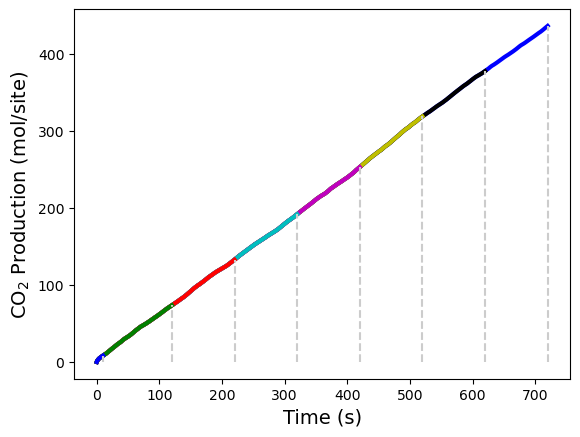

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel("CO$_2$ Production (mol/site)", fontsize=14)

colors = 'bgrcmykb'
for i in range(results.niterations()):
    for j in range(results.nreplicas()):
        molecule_numbers = results.children_results(i,j).molecule_numbers(['CO2'], normalize_per_site=True)
        
        ax.plot( molecule_numbers['Time'], molecule_numbers['CO2'], lw=3, color=colors[i], zorder=-i )
        ax.vlines( max(molecule_numbers['Time']) , 0, max(molecule_numbers['CO2']), colors='0.8', linestyles='--',)

plt.show()